In [39]:
import cv2
import torch
import torchvision
import torchvision.datasets as datasets
import albumentations as A
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os

In [40]:
_root = "/media/mountHDD3/data_storage/z2h/chestX_ray/data/chest_xray/chest_xray"
print(os.listdir(_root))

['val', '.DS_Store', 'test', 'train']


In [41]:
train_dir = _root + "/train"
val_dir = _root + "/val"
test_dir = _root + "/test"

normal_train_dir = train_dir + "/NORMAL"
pneumonia_train_dir = train_dir + "/PNEUMONIA"

normal_val_dir = val_dir + "/NORMAL"
pneumonia_val_dir = val_dir + "/PNEUMONIA"

normal_test_dir = test_dir + "/NORMAL"
pneumonia_test_dir = test_dir + "/PNEUMONIA"

print(f"No. NORMAL Train Img: {len(os.listdir(normal_train_dir))}")
print(f"No. PNEUMONIA Train Img: {len(os.listdir(pneumonia_train_dir))}")

print(f"No. NORMAL Val Img: {len(os.listdir(normal_val_dir))}")
print(f"No. PNEUMONIA Val Img: {len(os.listdir(pneumonia_val_dir))}")

print(f"No. NORMAL Test Img: {len(os.listdir(normal_test_dir))}")
print(f"No. PNEUMONIA Test Img: {len(os.listdir(pneumonia_test_dir))}")

No. NORMAL Train Img: 1342
No. PNEUMONIA Train Img: 3876
No. NORMAL Val Img: 9
No. PNEUMONIA Val Img: 9
No. NORMAL Test Img: 234
No. PNEUMONIA Test Img: 390


In [42]:
from glob import glob
train_normal_paths = sorted(glob(normal_train_dir + "/*"), key=lambda x: int(''.join(filter(str.isdigit, x))))
train_pneumonia_paths = sorted(glob(pneumonia_train_dir + "/*"), key=lambda x: int(''.join(filter(str.isdigit, x))))

idx = 0
sample_normal_path, sample_pneumonia_path = train_normal_paths[idx], train_pneumonia_paths[idx]

print(sample_normal_path)
print(sample_pneumonia_path)

/media/mountHDD3/data_storage/z2h/chestX_ray/data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg
/media/mountHDD3/data_storage/z2h/chestX_ray/data/chest_xray/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg


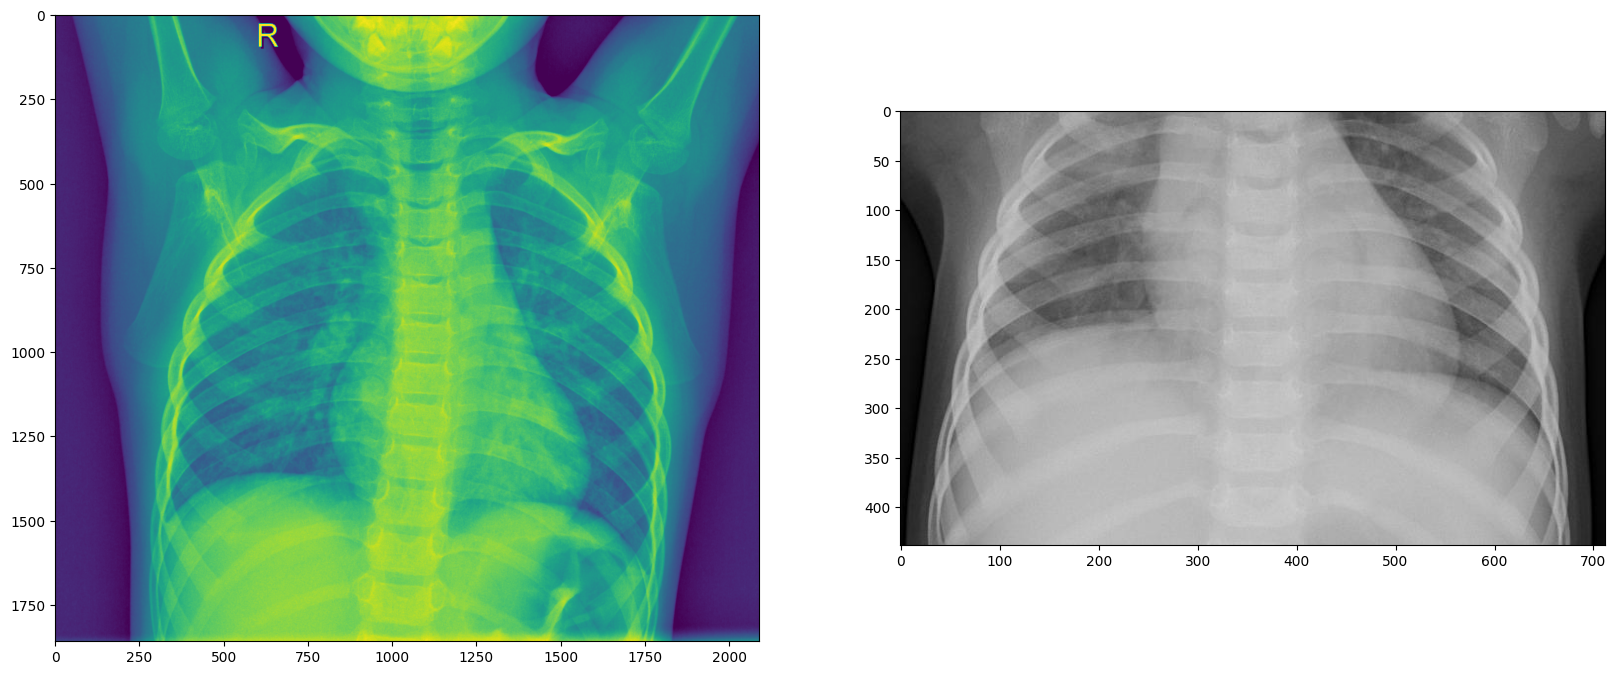

In [43]:
import matplotlib.pyplot as plt
sample_normal = Image.open(sample_normal_path)
sample_pneumonia = Image.open(sample_pneumonia_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(np.array(sample_normal))
ax2.imshow(np.array(sample_pneumonia), cmap = 'gray')

In [44]:
class ChestXray(Dataset):
    def __init__(self, root:str = _root, split = 'trainval', resize=(224,224)):
        super().__init__()
        self.root = root
        self._split = split
        self.__mode = "train" if self._split == 'trainval' else 'test'

        data_transforms={
          'train': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
          ]),
          'val': transforms.Compose([
              transforms.RandomResizedCrop(max(resize)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
          ]),
          'test': transforms.Compose([
              transforms.RandomResizedCrop(max(resize)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
          ])
        }

        
    def __len__(self):
        return len(self._normal), len(self._pneumonia)
    
    def __getitem__(self, idx):
        (normal, pneumonia) = super().__getitem__(idx)

        normal = np.array(Image.open(self._normal[idx]).convert("RGB"))
        pneumonia = np.array(Image.open(self._pneumonia[idx])) 

        resized = self.resize(image=normal, mask=pneumonia)

        if self.__mode == 'train':
            transformed = self.aug_transforms(image=resized['normal'], mask=resized['pneumonia'])
            transformed_normal = self.norm(image=transformed['normal'])['normal']
            transformed_pneumonia = self.norm(mask=transformed['pneumonia'])['pneumonia']
            
        else:
            transformed_normal = self.norm(image=resized['normal'])['normal']
            transformed_pneumonia = self.norm(mask=resized['pneumonia'])['pneumonia']
            
        torch_normal = torch.from_numpy(transformed_normal).permute(-1, 0, 1).float()
        torch_pneumonia = torch.from_numpy(transformed_pneumonia).permute(-1, 0, 1).float()

        # print(torch_mask.shape())

        return torch_normal, torch_pneumonia

    @property
    def mode(self):
        return self.__mode

    @mode.setter
    def mode(self, m):
        if m not in ['train', 'test']:
            raise ValueError(f"mode cannot be {m} and must be ['train', 'test']")
        else:
            self.__mode = m

# def get_ds():
#     train_data = ChestXray(
#         root = _root,
#         split = "trainval",
#         # target_types = "classification",
#     )

#     test_data = ChestXray(
#         root = _root,
#         split = "test",
#         # target_types = "classification",
#     )

#     val_size = int(len(train_data) * 0.1)
#     train_size = len(train_data) - val_size
#     train_data, val_data = random_split(train_data, [train_size, val_size])

#     train_dl = DataLoader(train_data, batch_size=64, shuffle=True)

#     val_dl = DataLoader(val_data, batch_size=64, shuffle=True)

#     test_dl = DataLoader(test_data, batch_size=64, shuffle=True)

#     return train_dl, val_dl, test_dl

In [45]:
train_dl, val_dl, test_dl = get_ds()

print(f"#TRAIN batch: {len(train_dl)}")
print(f"#VAL batch: {len(val_dl)}")
print(f"#TEST batch: {len(test_dl)}")

TypeError: 'tuple' object cannot be interpreted as an integer

In [48]:
data_dir="/media/mountHDD3/data_storage/z2h/chestX_ray/data/chest_xray/chest_xray"
def loadTrainData(data_dir,resize=(224,224)):
  data_transforms={
      'train': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ]),
      'val': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ]),
      'test': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ])
      
  }
  dataset={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
          for x in ['train','test','val']}
  dataset_loader={x:torch.utils.data.DataLoader(dataset[x],
                                                batch_size=64,
                                               shuffle=True)
                 for x in ['train','test','val']}
  dataset_size={x:len(dataset[x]) for x in ['train','test','val']}
  dataset_classes=dataset['train'].classes
  return dataset_loader['train'],dataset_loader['val'],dataset_loader['test']

In [49]:
train_loader, val_loader,test_loader=loadTrainData(data_dir)

In [50]:
print(f"#TRAIN batch: {len(train_loader)}")
print(f"#VAL batch: {len(val_loader)}")
print(f"#TEST batch: {len(test_loader)}")

#TRAIN batch: 82
#VAL batch: 1
#TEST batch: 10


In [51]:
import torch
import torch.nn as nn
from torchvision.models import densenet121

class DenseNet121(nn.Module):
    def __init__(self, n_classes):
        super(DenseNet121, self).__init__()
        self.densenet121 = densenet121(pretrained=True)
        n_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(n_features, n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

# Example usage
if __name__ == "__main__":
    n_classes = 10  # Specify the number of classes
    model = DenseNet121(n_classes)

    # Verify that the model is created successfully
    print(model)

    # Test with a dummy input
    dummy_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 color channels, 224x224 image size
    output = model(dummy_input)
    print(output)

/media/mountHDD2/duong/git/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mountHDD2/duong/git/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome